# Решение: автодополнение текста

В ноутбуке используются реализованные функции из src/:
- подготовка/сплит данных
- токенизация и словарь
- обучение LSTM-автодополнения
- оценка ROUGE для LSTM и DistilGPT-2
- вывод примеров и сохранение кратких отчётов в папку models/

Особенности решения:
- специальный TweetTokenizer() для этих текстов из sentiment140.
- SortedBatchSampler чтобы ускорить обучение. 
- weight tying в LSTMAutocomplete: self.fc.weight = self.embedding.weight для улучшения качества и ускорения.
- в LSTMAutocomplete.generate_batch применяется nucleus top_p, что улучшает качество выдачи.

In [1]:
import os
import sys
from pathlib import Path

# Убедимся, что корень репозитория и папка src на пути
ROOT = Path.cwd()
SRC = ROOT / "src"
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

print("Root:", ROOT)
print("Src :", SRC)

Root: C:\Users\Design\Downloads\for_yandex_NLP_course\project1\text-autocomplete
Src : C:\Users\Design\Downloads\for_yandex_NLP_course\project1\text-autocomplete\src


In [2]:
# Импорт реализованных функций и необходимых пакетов
import yaml
import torch
import torch.nn as nn

from src.data_utils import (
    set_seed,
    load_lines,
    clean_and_tokenize,
    build_vocabulary,
    save_summary,
    split_and_save_texts,
    select_examples_by_indices,
    print_selected_examples,
)
from src.next_token_dataset import build_dataloaders
from src.lstm_model import LSTMAutocomplete
from src.eval_lstm import evaluate_rouge_lstm
from src.eval_transformer_pipeline import evaluate_rouge_gpt2

C:\ProgramData\Anaconda3\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\ProgramData\Anaconda3\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [10]:
# Загрузка конфига
cfg_path = Path("configs/default.yaml")
assert cfg_path.exists(), f"Не найден конфиг {cfg_path}"
with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

In [3]:
# Фиксируем сид и девайс
set_seed(cfg.get("seed", 123))
device = torch.device("cuda" if torch.cuda.is_available() and cfg.get("device", "auto") != "cpu" else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [4]:
# Подготовка сплитов (если уже есть data/train.txt / val.txt / test.txt, этот шаг пропустится)
train_path = Path(cfg["data"]["train_path"]).resolve()
val_path   = Path(cfg["data"]["val_path"]).resolve()
test_path  = Path(cfg["data"]["test_path"]).resolve()

if not (train_path.exists() and val_path.exists() and test_path.exists()):
    print("Не найдены train/val/test — пытаемся сделать сплит из raw датасета...")
    # ВАЖНО: укажите путь к исходному raw датасету, если хотите собрать сплиты автоматически
    RAW_DATA_PATH = Path("data/raw_dataset.txt").resolve()
    assert RAW_DATA_PATH.exists(), (
        "Raw датасет не найден. Положите файл в data/raw_dataset.txt или подготовьте data/train.txt, data/val.txt, data/test.txt"
    )
    split_and_save_texts(
        input_path=RAW_DATA_PATH,
        output_dir=train_path.parent,
        # используем дефолты функции (val_size=0.1, test_size=0.1), seed возьмём из конфига
        seed=cfg.get("seed", 123),
    )
else:
    print("Найдены существующие сплиты train/val/test — пропускаем разбиение.")

print("train:", train_path)
print("val  :", val_path)
print("test :", test_path)

Найдены существующие сплиты train/val/test — пропускаем разбиение.
train: C:\Users\Design\Downloads\for_yandex_NLP_course\project1\text-autocomplete\data\train.txt
val  : C:\Users\Design\Downloads\for_yandex_NLP_course\project1\text-autocomplete\data\val.txt
test : C:\Users\Design\Downloads\for_yandex_NLP_course\project1\text-autocomplete\data\test.txt


In [5]:
# Загрузка текстов из файлов
train_texts = load_lines(train_path)
val_texts   = load_lines(val_path)
test_texts  = load_lines(test_path)

print(f"Загружено: train={len(train_texts)}, val={len(val_texts)}, test={len(test_texts)}")

# Токенизация для LSTM (TweetTokenizer + простая чистка)
train_tokens = clean_and_tokenize(train_texts)
val_tokens   = clean_and_tokenize(val_texts)
test_tokens  = clean_and_tokenize(test_texts)

print(f"После токенизации: train={len(train_tokens)}, val={len(val_tokens)}, test={len(test_tokens)}")
# Пример первых 2 токенизированных твитов
for i in range(min(2, len(train_tokens))):
    print(f"train[{i}] tokens:", train_tokens[i])

Загружено: train=1280398, val=160050, test=160050
После токенизации: train=1280398, val=160050, test=160050
train[0] tokens: ['<user>', 'boo']
train[1] tokens: ['<user>', 'we', 'came', 'to', 'the', 'studio', 'but', 'no', 'one', 'was', 'there', '...', 'gonna', 'go', 'through', 'video', 'footage', 'tomorrow', 'with', 'femi', '!']


In [6]:
# Построение словаря
vocab, inv_vocab = build_vocabulary(
    train_tokens,
    max_size=cfg["vocab"]["max_size"],
    min_freq=cfg["vocab"]["min_freq"],
)
PAD, BOS, EOS, UNK = vocab["[PAD]"], vocab["[BOS]"], vocab["[EOS]"], vocab["[UNK]"]
vocab_size = len(vocab)
print(f"Размер словаря: {vocab_size}")
print("Спец-идентификаторы:", {"PAD": PAD, "BOS": BOS, "EOS": EOS, "UNK": UNK})

Размер словаря: 7480
Спец-идентификаторы: {'PAD': 0, 'BOS': 1, 'EOS': 2, 'UNK': 3}


In [7]:
# Посмотрим покрытие словаря (оценим долю [UNK] в train)
total_tokens = sum(len(x) for x in train_tokens)
unk_tokens = sum(sum(1 for t in x if vocab.get(t, UNK) == UNK) for x in train_tokens)
if total_tokens > 0:
    print(f"Доля UNK в train: {unk_tokens/total_tokens:.3%}")
else:
    print("Пустой train после токенизации — проверьте входные данные")

Доля UNK в train: 5.844%


In [8]:
# Сборка DataLoader'ов
max_len    = cfg["train"]["max_len"]
batch_size = cfg["train"]["batch_size"]
pin_memory = (device.type == "cuda")

train_loader, val_loader, test_loader = build_dataloaders(
    train_tokens, val_tokens, test_tokens, vocab,
    max_len=max_len, batch_size=batch_size, pin_memory=pin_memory
)
print("Dataloaders готовы")

Dataloaders готовы


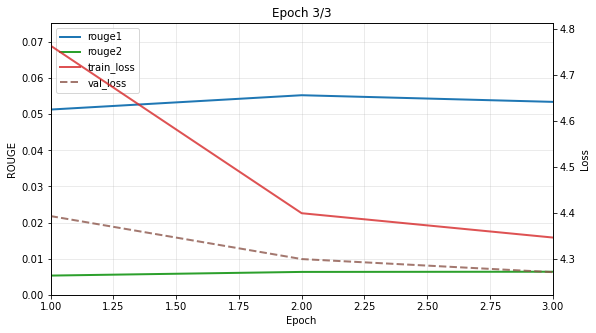

Лучшие LSTM-результаты (val): {'rouge1': 0.05342658459237559, 'rouge2': 0.006390099452026053, 'rougeL': 0.05331739120008722, 'rougeLsum': 0.053344814419016576}
Примеры (val):
PREFIX: its a beautiful day to be mothers day ! i love you so much , mom ! more than you can know ! happy
PRED:   birthday to me ! ! !
REF:    mothers day to all the moms ! you
---
PREFIX: i almost slept at a normal time . i [UNK] for two hours at a normal time . but then i [UNK] got up
PRED:   early .
REF:    to do something . i am awake now
---
PREFIX: changed my [UNK] , but it isn't good as it supposed to be ~ ~ n i don't think it [UNK] that much money
PRED:   !
REF:    .. hate that [UNK] ~ ~ ;(
---
PREFIX: <user> hahahaha ! oh my god ! ! ! can i come eat with you ? i'll cook some good old [UNK] mac n
PRED:   my shoe .
REF:    ' cheese with fancy [UNK] [UNK] .
---
PREFIX: folder and i finally see how much i need to change for you . it's going to happen okay ... so whatever you do
PRED:   
REF:    , don't give u

In [9]:
# Инициализация модели и обучение (с использованием реализованной train_with_plotting)
from src.lstm_train import train_with_plotting  # ВАЖНО: модуль с обучением должен называться src/train.py

model = LSTMAutocomplete(
    vocab_size=vocab_size,
    emb_dim=cfg["model"]["emb_dim"],
    hidden_dim=cfg["model"]["hidden_dim"],
    num_layers=cfg["model"]["num_layers"],
    dropout=cfg["model"]["dropout"],
    pad_idx=PAD,
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=cfg["train"]["lr"],
    weight_decay=cfg["train"]["weight_decay"],
)
criterion = nn.CrossEntropyLoss(ignore_index=PAD, reduction="mean")

hist, best_lstm_results, fig, best_lstm_examples = train_with_plotting(
    model, train_loader, val_loader, optimizer, criterion,
    inv_vocab, PAD, BOS, EOS, UNK, device, max_len,
    num_epochs=cfg["train"]["epochs"],
    quarter=cfg["train"]["quarter"],
    do_sample=cfg["train"]["do_sample"],
    top_p=cfg["train"]["top_p"],
    temperature=cfg["train"]["temperature"],
    num_show=cfg["train"]["num_show"],
    ckpt_dir=cfg["train"]["ckpt_dir"],
    save_best=cfg["train"]["save_best"],
    clip_norm=cfg["train"]["clip_norm"],
    use_plot=cfg["train"].get("use_plot", False),
)

print("Лучшие LSTM-результаты (val):", best_lstm_results)
if best_lstm_examples:
    print("Примеры (val):")
    for ex in best_lstm_examples[:min(5, len(best_lstm_examples))]:
        print("PREFIX:", ex["prefix"]) 
        print("PRED:  ", ex["prediction"])
        print("REF:   ", ex["reference"]) 
        print("---")

# Сохраним краткое резюме
#save_summary(best_lstm_results, best_lstm_examples, out_dir=cfg["train"]["ckpt_dir"], filename_prefix="lstm_results", top_k=5)

In [11]:
# Оценка DistilGPT-2 (baseline) на val и test с помощью реализованной evaluate_rouge_gpt2
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = cfg["transformer_eval"]["model_name"]
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
gpt2_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
gpt2_model.config.pad_token_id = tokenizer.pad_token_id

subset_n = cfg["transformer_eval"].get("subset_n", None)
val_texts_for_eval = val_texts[:subset_n] if subset_n is not None else val_texts
test_texts_for_eval = test_texts[:subset_n] if subset_n is not None else test_texts

# Val
gpt2_val_results, gpt2_val_examples = evaluate_rouge_gpt2(
    text_list=val_texts_for_eval,
    tokenizer=tokenizer,
    model=gpt2_model,
    device=device,
    quarter=cfg["transformer_eval"]["quarter"],
    do_sample=True,
    top_k=cfg["transformer_eval"]["top_k"],
    top_p=cfg["transformer_eval"]["top_p"],
    temperature=cfg["transformer_eval"]["temperature"],
    num_show=cfg["transformer_eval"]["num_show"],
    max_length=cfg["transformer_eval"]["max_length"],
)
print("GPT-2 val results:", gpt2_val_results)

# Печать выбранных примеров по индексам из конфига (без выхода за границы)
example_ids = cfg["transformer_eval"].get("example_ids", [])
safe_ids = [i for i in example_ids if 0 <= i < len(gpt2_val_examples)]
gpt2_val_selected_examples = select_examples_by_indices(gpt2_val_examples, safe_ids) if safe_ids else []
if gpt2_val_selected_examples:
    print_selected_examples(gpt2_val_selected_examples)

#save_summary(gpt2_val_results, gpt2_val_selected_examples, out_dir=cfg["train"]["ckpt_dir"], filename_prefix="gpt2_val_results", top_k=5)

C:\ProgramData\Anaconda3\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Eval GPT-2:   0%|                                                                            | 0/10000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\transformers\generation\utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Eval GPT-2: 100%|████████████████████████████████████████████████████████████████| 10000/10000 [08:29<00:00, 19.63it/s]


Обработано 9857 примеров
GPT-2 val results: {'rouge1': 0.07148325119153526, 'rouge2': 0.0072525543510630255, 'rougeL': 0.07109398290747442, 'rougeLsum': 0.0711247239678809}
Examples:
PREFIX:  <user> hahahaha! Oh my God!!! Can I come eat with you? I'll cook some good old fashioned mac n'
PRED:    gravy! (and maybe make me the first
REF:      cheese with fancy dijon ketchups.
---
Examples:
PREFIX:  Its a beautiful day to be mothers day! I love you SO much, mom! More than you can know! Happy Mothers day
PRED:    !

This week we're sharing
REF:      to all the moms! You rock!
---
Examples:
PREFIX:  I almost slept at a normal time. I dozed for two hours at a normal time. But then I stupidly got up to
PRED:    sleep.
“It“
REF:      do something. I am awake now.
---
Examples:
PREFIX:  Changed my hairstyle,but it isn't good as it supposed to be~~N I don't think it wealthed that much money..
PRED:    I really do think it would be cool if
REF:      hate that hairdresser~~;(
---
Examples:
PREFIX:

In [12]:
# Test
gpt2_test_results, gpt2_test_examples = evaluate_rouge_gpt2(
    text_list=test_texts_for_eval,
    tokenizer=tokenizer,
    model=gpt2_model,
    device=device,
    quarter=cfg["transformer_eval"]["quarter"],
    do_sample=True,
    top_k=cfg["transformer_eval"]["top_k"],
    top_p=cfg["transformer_eval"]["top_p"],
    temperature=cfg["transformer_eval"]["temperature"],
    num_show=min(cfg["transformer_eval"]["num_show"], 10),  # выводим поменьше примеров в ноутбуке
    max_length=cfg["transformer_eval"]["max_length"],
)
print("GPT-2 test results:", gpt2_test_results)
if gpt2_test_examples:
    print_selected_examples(gpt2_test_examples[:5])

#save_summary(gpt2_test_results, gpt2_test_examples, out_dir=cfg["train"]["ckpt_dir"], filename_prefix="gpt2_test_results", top_k=5)

Eval GPT-2: 100%|████████████████████████████████████████████████████████████████| 10000/10000 [08:19<00:00, 20.03it/s]


Обработано 9855 примеров
GPT-2 test results: {'rouge1': 0.06790248609144076, 'rouge2': 0.00732532392349744, 'rougeL': 0.06738347937558839, 'rougeLsum': 0.06737092471317493}
Examples:
PREFIX:  <user> for real, i used to
PRED:    have a few
REF:      live skips
---
Examples:
PREFIX:  <user> ouch dave
PRED:    a
REF:      that hurts
---
Examples:
PREFIX:  I want my mom
PRED:    to
REF:     my
---
Examples:
PREFIX:  <user> thank you for the laugh this morning! I hated that it was
PRED:    so funny and fun.
REF:      at your expense though!
---
Examples:
PREFIX:  <user> What's wrong
PRED:    with
REF:     ?
---


# Выводы

- Мы обучили простую LSTM-модель автодополнения на токенизированных твитах и оценили качество на валидации/тесте по ROUGE-1/ROUGE-2. В ноутбуке напечатаны лучшие метрики и несколько примеров.
- В качестве базовой модели также оценили DistilGPT-2 на той же задаче и сравнили ROUGE с LSTM.
- Ожидаемо, предобученная DistilGPT-2 часто показывает более высокие ROUGE-метрики, особенно при небольшом количестве эпох обучения LSTM и высоком пороге min_freq в словаре. Тем не менее, качество LSTM можно улучшать увеличением количества эпох, снижением min_freq, тюнингом размера словаря, кол-вом слоев, а также регуляризацией и настройкой стратегии сэмплирования.
- В папке models/ сохранены краткие текстовые отчёты с метриками и примерами для LSTM и GPT-2.